# **2: DuckDB's Python API**

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

Source: 
- [Getting Started with DuckDB](https://www.packtpub.com/en-ar/product/getting-started-with-duckdb-9781803232539) by Simon Aubury & Ned Letcher
- [DuckDB documentation](https://duckdb.org/docs/)
---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/DuckDB/notebooks/1_duckdb_intro.ipynb).

---

This is part 2 of the series of notebooks on DuckDB.  
This time I will show how to use DuckDB with Python for data analysis. When I say use DuckDB i mostly refer to the APIs that are available for this purpose.

As such you will find a lot more text than code as I also explain:
- **[why](#why-use-duckdb)** do we use DuckDB
- **[when](#when-not-to-use-duckdb)** to not use it
- **[how to install](#installing-duckdb-cli)** DuckDB CLI
  - I briefly show a **couple of queries** using the DuckDB CLI, introducing what is a dot command (example with .mode). 
- and how to **[set it up](#setting-up-duckdb-for-python) for use in Python**:
  - as a **default in-memory** (temp) database
  - as a **[persistent](#persistent-new-connection)** more flexible database
- and a brief intro to **[extensions](#extensions)** install

  
The setup for Python use takes about half of this notebook as it is the main focus here. The goal is to **show, in the following notebooks, the analytical abilities** of DuckDB coupled with Polars, Pandas and pyarrow.  

**The two main takeaways are**:
- to understand the **difference between in-memory and persistent** databases. 
- The other is to keep in mind **one major limitation of DuckDB**, explained in the [point 3 of this parag](#when-not-to-use-duckdb).

---


## **Imports**:


In [1]:
from duckdb import ColumnExpression, ConstantExpression
import sqlparse
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Add parent directory to sys.path
sys.path.append(os.path.abspath(".."))

## **The Seattle Pet's Licenses Dataset**: 

I will use that dataset to demonstrate DuckDB API's features.  
I downloaded it as a csv file. It is in the data/data_in folder. You can also download it [directly here](https://data.seattle.gov/City-Administration/Seattle-Pet-Licenses/jguv-t9rb/about_data).  

This is about 43.5K rows and 7 columns.  

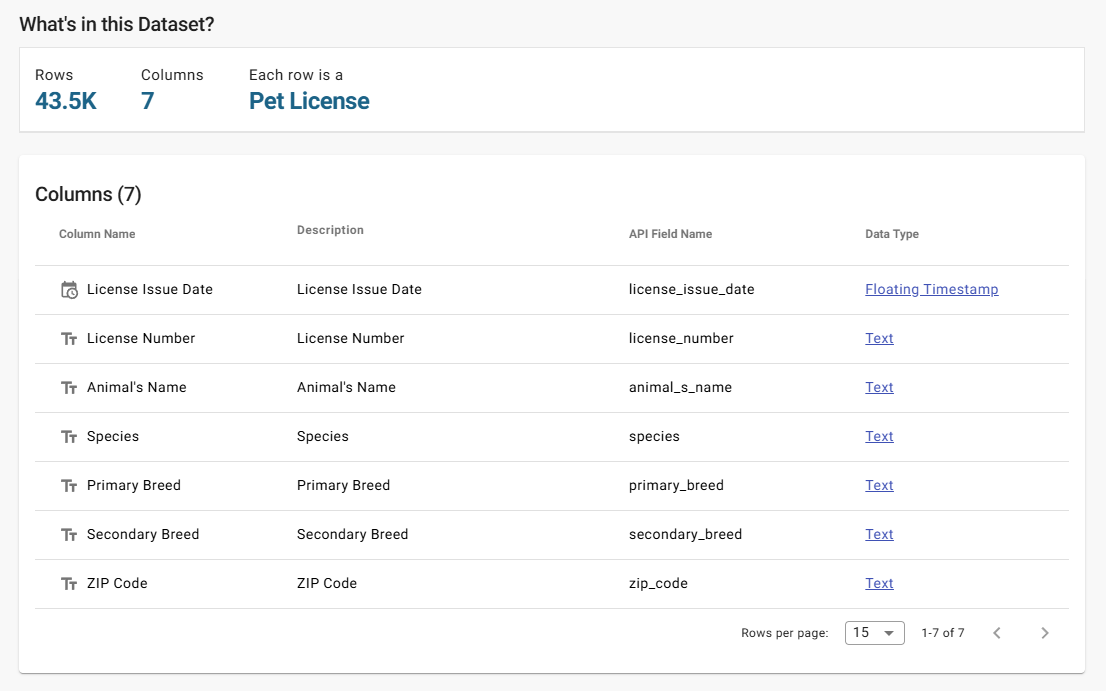

## Using the Relational API: 

Think of DuckDB's Relational API like a **recipe plan** for cooking a meal.

A relation (**DuckDBPyRelation** object) is **NOT the final dish**; it’s a **step-by-step recipe** that describes how to cook it. 

When you build a relation, you’re just writing down the **instructions** (the query structure), but you don’t actually start cooking (executing the query) yet.

> Laziness = Cooking starts only when needed → The meal (query result) is only prepared when you decide to serve it (display, save, or use the data).

A relation object is **linked to a specific DuckDB database**, so the sql() method must be called on a connection object.  

Let's create a simple relational object with the pi() function:

In [2]:
import duckdb

In [3]:
pi_rltn = duckdb.sql(
    "select pi() as pi"
)
type(pi_rltn)

duckdb.duckdb.DuckDBPyRelation

I did create a relational object because its type is `.DuckDBPyRelation`. I know that because I used the type() function.  
Note that it is linked to the default in-memory database. 

### **.show() or not**:

To return the result of that query that is now in the variable pi_rltn I need to use the `.show()` method.

In [4]:
pi_rltn.show()

┌───────────────────┐
│        pi         │
│      double       │
├───────────────────┤
│ 3.141592653589793 │
└───────────────────┘



**NOTE**:  
The sql() method I used in the relational object **only returns it if** the SQL query **contains a SELECT statement**.

A nice thing with relational object is that if it is at the end of code line, I do not have to use .show() to display its result: 

In [5]:
pi_rltn

┌───────────────────┐
│        pi         │
│      double       │
├───────────────────┤
│ 3.141592653589793 │
└───────────────────┘

### Loading Dataset with Relational: 

I now use the read_csv() method of the default databse duckdb to load the pet licenses dataset:

In [6]:
# Get the base directory from the environment variable
base_dir = os.getenv('BASE_DIR')

# Construct the file path
file_path = Path(base_dir) / 'data/data_in/Seattle_Pet_Licenses_20250216.csv'

# Use the constructed file path in the read_csv function
duckdb.sql(
    f'''
    select *
    from read_csv('{file_path}')
    '''
)

┌────────────────────┬────────────────┬───────────────┬─────────┬──────────────────────┬────────────────────┬──────────┐
│ License Issue Date │ License Number │ Animal's Name │ Species │    Primary Breed     │  Secondary Breed   │ ZIP Code │
│      varchar       │    varchar     │    varchar    │ varchar │       varchar        │      varchar       │  int64   │
├────────────────────┼────────────────┼───────────────┼─────────┼──────────────────────┼────────────────────┼──────────┤
│ December 18 2015   │ S107948        │ Zen           │ Cat     │ Domestic Longhair    │ Mix                │    98117 │
│ June 14 2016       │ S116503        │ Misty         │ Cat     │ Siberian             │ NULL               │    98117 │
│ August 04 2016     │ S119301        │ Lyra          │ Cat     │ Mix                  │ NULL               │    98121 │
│ August 10 2019     │ S133113        │ Spider        │ Cat     │ LaPerm               │ NULL               │    98115 │
│ November 20 2020   │ 77412    

See the last line of the output? DuckDB **returned about 10,000 rows** of the dataset and if look carefully you can also see the number 7 at the far right, for 7 columns returned, which was expected. 

This **"lazy" automatic behavior is off** when exporting to a pandas dataframe or writting on disk, which means **nothing is skipped**, I get the whole complete dataset. 

Let's instantiate that relational object of our pet dataset: 

In [7]:
pets_csv_rltn = duckdb.read_csv(f'{file_path}')

Did you notice in the table output that the first column data type is VARCHAR. This means it's a text. But values are dates for that License Issue Date column.  

### Loading & assigning data types:

I could change that data  type in my instatiation, let's see how:

In [8]:
pets_csv_rltn = duckdb.read_csv(
    f"{file_path}",
    dtype={"License Issue Date": "DATE"},
    date_format="%B %d %Y",
)
pets_csv_rltn.types

[DATE, VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, BIGINT]

The first column is effectively a DATE type column now.  

I want to look at the table again, but only at the first 5 rows: 

In [9]:
pets_csv_rltn.limit(5)

┌────────────────────┬────────────────┬───────────────┬─────────┬───────────────────┬────────────────────┬──────────┐
│ License Issue Date │ License Number │ Animal's Name │ Species │   Primary Breed   │  Secondary Breed   │ ZIP Code │
│        date        │    varchar     │    varchar    │ varchar │      varchar      │      varchar       │  int64   │
├────────────────────┼────────────────┼───────────────┼─────────┼───────────────────┼────────────────────┼──────────┤
│ 2015-12-18         │ S107948        │ Zen           │ Cat     │ Domestic Longhair │ Mix                │    98117 │
│ 2016-06-14         │ S116503        │ Misty         │ Cat     │ Siberian          │ NULL               │    98117 │
│ 2016-08-04         │ S119301        │ Lyra          │ Cat     │ Mix               │ NULL               │    98121 │
│ 2019-08-10         │ S133113        │ Spider        │ Cat     │ LaPerm            │ NULL               │    98115 │
│ 2020-11-20         │ 77412          │ Gemma         │ 

**Other file types too**: 
I could also read parquet and json files with these functions:
- .read_parquet()
- .read_json()

To get the full set of parameters, the help function is available:

In [10]:
help(duckdb.read_csv)

Help on built-in function read_csv in module duckdb.duckdb:

read_csv(...) method of builtins.PyCapsule instance
    read_csv(path_or_buffer: object, **kwargs) -> duckdb.duckdb.DuckDBPyRelation

    Create a relation object from the CSV file in 'name'



The Relational API is a way to use Python to interact with DuckDB, which is the **same system that DuckDB SQL uses**. This means you can **use SQL queries to get the same results as using the Relational API methods**. You can also mix both in your work based on what you prefer.  

Relation objects have a helpful method called sql_query() that gives you the SQL query that matches the relation.

In [11]:
print(pets_csv_rltn.sql_query())

SELECT * FROM read_csv_auto(['F:\DATA Scientist\VSCODE_DataScience_JyTRAN\Data_ML_Practice_2025\1-3-SQL\practice\DuckDB\data\data_in\Seattle_Pet_Licenses_20250216.csv'], (delim = ','), ("skip" = 0), (dateformat = '%B %d %Y'), (max_line_size = 2000000), ("quote" = '"'), ("header" = true), ("escape" = '"'), (null_padding = false), ("parallel" = true), (normalize_names = false), (all_varchar = false), (auto_detect = false), ("columns" = {'License Issue Date': 'DATE', 'License Number': 'VARCHAR', 'Animal's Name': 'VARCHAR', 'Species': 'VARCHAR', 'Primary Breed': 'VARCHAR', 'Secondary Breed': 'VARCHAR', 'ZIP Code': 'BIGINT'}))


### Relations from tables:  

I can also create a relation object from an existing DuckDB table. For that I first need to create the table `seattle_pets_ds`

In [12]:
pets_csv_rltn.to_table(
    "seattle_pets_ds"
)

duckdb.sql("show tables")

┌─────────────────┐
│      name       │
│     varchar     │
├─────────────────┤
│ seattle_pets_ds │
└─────────────────┘

Now I can make it a relation object:

In [13]:
pets_table_rltn = duckdb.table("seattle_pets_ds")

For those who know pandas, the `.describe()` table is also available in DuckDB. 

In [14]:
pets_table_rltn.describe()

┌─────────┬────────────────────┬────────────────┬────────────────────┬─────────┬───────────────────┬───────────────────┬────────────────────┐
│  aggr   │ License Issue Date │ License Number │   Animal's Name    │ Species │   Primary Breed   │  Secondary Breed  │      ZIP Code      │
│ varchar │      varchar       │    varchar     │      varchar       │ varchar │      varchar      │      varchar      │       double       │
├─────────┼────────────────────┼────────────────┼────────────────────┼─────────┼───────────────────┼───────────────────┼────────────────────┤
│ count   │ 43460              │ 43460          │ 43417              │ 43460   │ 43460             │ 30124             │            43312.0 │
│ mean    │ NULL               │ NULL           │ NULL               │ NULL    │ NULL              │ NULL              │  98086.17323143702 │
│ stddev  │ NULL               │ NULL           │ NULL               │ NULL    │ NULL              │ NULL              │ 1395.5918405381062 │
│ min 

Another useful function is `.count()`, which is just like the count SQL aggregation: 

In [15]:
# total number of rows:
pets_table_rltn.count("*")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│        43460 │
└──────────────┘

### Dropping a relation table:

There is no relation API drop function, I have to use the SQL one:

In [16]:
duckdb.sql(
    "drop table seattle_pets_ds")

In [17]:
duckdb.sql("SHOW TABLES")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ 0 rows  │
└─────────┘

## **Querying Relation Objects**:  

In Python, DuckDB lets you query existing data objects like relation objects **as if they were database tables**. You can use the **names** of these relation objects **in your SQL queries**, and DuckDB will treat them like tables in a database.  

I illustrate that by querying the pets licenses relation object (RO) in order to get a smaller version of it, I only want 4 columns out of the 7 it has. 

In [18]:
pets_4cols_rltn = duckdb.sql(
    """
    select
        "License Issue Date" as issue_date,
        "Animal's Name" as pet_name,
        "Species" as species,
        "Primary Breed" as breed,     
    from pets_csv_rltn  
    """
)
pets_4cols_rltn.limit(5)

┌────────────┬──────────┬─────────┬───────────────────┐
│ issue_date │ pet_name │ species │       breed       │
│    date    │ varchar  │ varchar │      varchar      │
├────────────┼──────────┼─────────┼───────────────────┤
│ 2015-12-18 │ Zen      │ Cat     │ Domestic Longhair │
│ 2016-06-14 │ Misty    │ Cat     │ Siberian          │
│ 2016-08-04 │ Lyra     │ Cat     │ Mix               │
│ 2019-08-10 │ Spider   │ Cat     │ LaPerm            │
│ 2020-11-20 │ Gemma    │ Cat     │ Siamese           │
└────────────┴──────────┴─────────┴───────────────────┘

And I can now continue to make more targetted custom relation object. I want the earliest (min) and latest (max) pet license issue dates: 

In [19]:
min_max_rltn = duckdb.sql(
    """
    select min(issue_date), max(issue_date)
    from pets_4cols_rltn
    """
)
min_max_rltn

┌─────────────────┬─────────────────┐
│ min(issue_date) │ max(issue_date) │
│      date       │      date       │
├─────────────────┼─────────────────┤
│ 2015-10-21      │ 2025-01-08      │
└─────────────────┴─────────────────┘

Under the hood DuckDB scanned the two relation objects: 
- `pets_csv_rltn`
- which is part of `pets_4col_rltn`

#### **Optimized Execution (Query Planning)**

So, relational objects let you **build queries step by step**, just like I did, applying transformations **without executing them immediately**.

If you **sequentially execute** multiple SQL queries, DuckDB materializes intermediate results, which **can slow down performance**.
With relational objects, DuckDB **delays execution and optimizes the whole query at once**, like an advanced CTE optimization.

Let's look at the query plan of our last relation object "min_max_rltn" with the .explain() method. 

In [20]:
min_max_rltn.explain()

''

Despite the multiple calls and the 2 intricate ROs, the **query plan is spot on**. 

## **Transforming with Relation Objects**:  

There are two main approaches:   
- with SQL  
- with more RO calls

### **SQL Approach**:
Let's see the SQL approach. 
I want to all records for pet licenses registered on pigs. 

In [21]:
duckdb.sql(
    """
    SELECT *
    FROM pets_4cols_rltn
    WHERE species = 'Pig'
    """
)

┌────────────┬───────────────────────┬─────────┬─────────────┐
│ issue_date │       pet_name        │ species │    breed    │
│    date    │        varchar        │ varchar │   varchar   │
├────────────┼───────────────────────┼─────────┼─────────────┤
│ 2024-05-10 │ Calvin                │ Pig     │ Pot-Bellied │
│ 2024-06-07 │ Waffles Olivia McHart │ Pig     │ Pot-Bellied │
│ 2024-08-08 │ Millie                │ Pig     │ Pot-Bellied │
└────────────┴───────────────────────┴─────────┴─────────────┘

Now, with the RO approach, which gives us the option to use a chaining method, `.filter()`

In [22]:
pets_4cols_rltn.filter(
    "species = 'Pig'")

┌────────────┬───────────────────────┬─────────┬─────────────┐
│ issue_date │       pet_name        │ species │    breed    │
│    date    │        varchar        │ varchar │   varchar   │
├────────────┼───────────────────────┼─────────┼─────────────┤
│ 2024-05-10 │ Calvin                │ Pig     │ Pot-Bellied │
│ 2024-06-07 │ Waffles Olivia McHart │ Pig     │ Pot-Bellied │
│ 2024-08-08 │ Millie                │ Pig     │ Pot-Bellied │
└────────────┴───────────────────────┴─────────┴─────────────┘

That's a lot less verbose. Be aware of the wrapping double quotes " " and inside it, the ' '.  

What about all cats with the name Rocky?

In [23]:
pets_4cols_rltn.filter(
    "species = 'Cat' AND pet_name = 'Rocky'")

┌────────────┬──────────┬─────────┬──────────────────────┐
│ issue_date │ pet_name │ species │        breed         │
│    date    │ varchar  │ varchar │       varchar        │
├────────────┼──────────┼─────────┼──────────────────────┤
│ 2023-01-23 │ Rocky    │ Cat     │ Mix                  │
│ 2023-02-09 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-02-26 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-03-01 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-05-01 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-05-07 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-08-05 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-09-23 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-10-15 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-10-27 │ Rocky    │ Cat     │ American Shorthair   │
│ 2024-04-06 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2024-05-03 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2024-06-07 │ Rocky    │ Cat     │ Domestic Shorthair  

Turns out Rocky is a very popular cat name in Seattle. 

### Expression API: 

Another way is to use classes from the Expression API to instantiate columns and values (called a constant by DuckDB) that I'd need in my .filter() method: 
- ColumnExpression
- ConstantExpression

In [24]:
species_col = ColumnExpression("species")
pig_constant = ConstantExpression("Pig")

pets_4cols_rltn.filter(species_col == pig_constant)

┌────────────┬───────────────────────┬─────────┬─────────────┐
│ issue_date │       pet_name        │ species │    breed    │
│    date    │        varchar        │ varchar │   varchar   │
├────────────┼───────────────────────┼─────────┼─────────────┤
│ 2024-05-10 │ Calvin                │ Pig     │ Pot-Bellied │
│ 2024-06-07 │ Waffles Olivia McHart │ Pig     │ Pot-Bellied │
│ 2024-08-08 │ Millie                │ Pig     │ Pot-Bellied │
└────────────┴───────────────────────┴─────────┴─────────────┘

Let's take that even further:

In [25]:
name_col = ColumnExpression("pet_name")
is_cat = species_col == ConstantExpression("Cat")
is_rocky = name_col == ConstantExpression("Rocky")

pets_4cols_rltn.filter(is_cat & is_rocky)

┌────────────┬──────────┬─────────┬──────────────────────┐
│ issue_date │ pet_name │ species │        breed         │
│    date    │ varchar  │ varchar │       varchar        │
├────────────┼──────────┼─────────┼──────────────────────┤
│ 2023-01-23 │ Rocky    │ Cat     │ Mix                  │
│ 2023-02-09 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-02-26 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-03-01 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-05-01 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-05-07 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-08-05 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-09-23 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2023-10-15 │ Rocky    │ Cat     │ American Shorthair   │
│ 2023-10-27 │ Rocky    │ Cat     │ American Shorthair   │
│ 2024-04-06 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2024-05-03 │ Rocky    │ Cat     │ Domestic Shorthair   │
│ 2024-06-07 │ Rocky    │ Cat     │ Domestic Shorthair  

I created multiple objects (they feel more like blocks to me) with which I constructed my RO. And they're reusable of course. 
The Expression API provides a **deeper use of Python**, giving me the flexibility of **building complex expressions**. 

## Chaining Methods:  

This technique is very simple, just like it implies, I just need to tail my code line with a method, which can be tailed by another method, creating a chain of methods.  
An easy example is to use the .filter() and chain it with a .limit() to return only 5 rows:

In [26]:
pets_4cols_rltn.filter(is_cat).limit(5)

┌────────────┬──────────┬─────────┬───────────────────┐
│ issue_date │ pet_name │ species │       breed       │
│    date    │ varchar  │ varchar │      varchar      │
├────────────┼──────────┼─────────┼───────────────────┤
│ 2015-12-18 │ Zen      │ Cat     │ Domestic Longhair │
│ 2016-06-14 │ Misty    │ Cat     │ Siberian          │
│ 2016-08-04 │ Lyra     │ Cat     │ Mix               │
│ 2019-08-10 │ Spider   │ Cat     │ LaPerm            │
│ 2020-11-20 │ Gemma    │ Cat     │ Siamese           │
└────────────┴──────────┴─────────┴───────────────────┘

Let's demonstrate that even further. I want to know the number of distinct names of cats. Here's how I can do it by chaining methods:

In [27]:
nbr_uniq_catsname_rltn = (
    pets_4cols_rltn
    .filter(is_cat)
    .select("pet_name")
    .distinct()
    .count("*")
)
nbr_uniq_catsname_rltn

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         6525 │
└──────────────┘

There is a shorter way to do this, with the .unique() method, which combines the select() and the distinct() in one method: 

In [28]:
nbr_uniq_catsname_rltn = (
    pets_4cols_rltn
    .filter(is_cat)
    .unique("pet_name")
    .count("*")
)
nbr_uniq_catsname_rltn

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         6525 │
└──────────────┘

Chaining methods this way is **possible thanks to the Relational API of DuckDB**. Each method encapsulates a new relation, holding the results of the operation just applied. Pandas works similarly, however the difference here is that the **DuckDB lazy execution waits to the latest possible moment** to execute the whole chain. There are no more intermediate operations like it is with Pandas. And this **positively impacts memory limitations**. 

#### Comparison with raw SQL

To have a better idea of what the raw SQL equivalent is I print it out using `.sql_query()`:

In [29]:
nbr_uniq_catsname_rltn_str = nbr_uniq_catsname_rltn.sql_query()
print(nbr_uniq_catsname_rltn_str)

SELECT count_star() FROM (SELECT DISTINCT pet_name FROM (SELECT * FROM (WITH pets_csv_rltn AS (SELECT * FROM (SELECT * FROM read_csv_auto(['F:\DATA Scientist\VSCODE_DataScience_JyTRAN\Data_ML_Practice_2025\1-3-SQL\practice\DuckDB\data\data_in\Seattle_Pet_Licenses_20250216.csv'], (delim = ','), ("skip" = 0), (dateformat = '%B %d %Y'), (max_line_size = 2000000), ("quote" = '"'), ("header" = true), ("escape" = '"'), (null_padding = false), ("parallel" = true), (normalize_names = false), (all_varchar = false), (auto_detect = false), ("columns" = {'License Issue Date': 'DATE', 'License Number': 'VARCHAR', 'Animal's Name': 'VARCHAR', 'Species': 'VARCHAR', 'Primary Breed': 'VARCHAR', 'Secondary Breed': 'VARCHAR', 'ZIP Code': 'BIGINT'}))))SELECT "License Issue Date" AS issue_date, "Animal's Name" AS pet_name, Species AS species, "Primary Breed" AS breed FROM pets_csv_rltn) AS unnamed_relation_90c67672babe1146 WHERE (species = 'Cat')) AS unnamed_relation_90c67672babe1146) AS unnamed_relation_90

Using the [module sqlparse](#imports) I want to see a better display of that raw SQL equivalent of my last chaining call:

In [30]:
raw_sql = sqlparse.format(
    nbr_uniq_catsname_rltn_str,
    reindent = True
)
print(raw_sql)

SELECT count_star()
FROM (
SELECT DISTINCT pet_name
FROM (
SELECT *
FROM (WITH pets_csv_rltn AS (
SELECT *
FROM
  (SELECT *
   FROM read_csv_auto(['F:\DATA Scientist\VSCODE_DataScience_JyTRAN\Data_ML_Practice_2025\1-3-SQL\practice\DuckDB\data\data_in\Seattle_Pet_Licenses_20250216.csv'], (delim = ','), ("skip" = 0), (dateformat = '%B %d %Y'), (max_line_size = 2000000), ("quote" = '"'), ("header" = true), ("escape" = '"'), (null_padding = false), ("parallel" = true), (normalize_names = false), (all_varchar = false), (auto_detect = false), ("columns" = {'License Issue Date': 'DATE', 'License Number': 'VARCHAR', 'Animal's Name': 'VARCHAR', 'Species': 'VARCHAR', 'Primary Breed': 'VARCHAR', 'Secondary Breed': 'VARCHAR', 'ZIP Code': 'BIGINT'}))))SELECT "License Issue Date" AS issue_date, "Animal's Name" AS pet_name, Species AS species, "Primary Breed" AS breed
                                                                                                                                      

Let's refactor this into a handy `convert_2rawSQL()` function. It is in the utils folder.  
I made it so it wont return the full path of the file in the FROM clause. 

In [31]:
from utils.duckdb_shared_code import convert_2rawSQL

In [32]:
convert_2rawSQL(nbr_uniq_catsname_rltn)

SELECT count_star()
FROM (
SELECT DISTINCT pet_name
FROM (
SELECT *
FROM (WITH pets_csv_rltn AS (
SELECT *
FROM
  (SELECT *
   FROM read_csv_auto([Seattle_Pet_Licenses_20250216.csv'], (delim = ','), ("skip" = 0), (dateformat = '%B %d %Y'), (max_line_size = 2000000), ("quote" = '"'), ("header" = true), ("escape" = '"'), (null_padding = false), ("parallel" = true), (normalize_names = false), (all_varchar = false), (auto_detect = false), ("columns" = {'License Issue Date': 'DATE', 'License Number': 'VARCHAR', 'Animal's Name': 'VARCHAR', 'Species': 'VARCHAR', 'Primary Breed': 'VARCHAR', 'Secondary Breed': 'VARCHAR', 'ZIP Code': 'BIGINT'}))))SELECT "License Issue Date" AS issue_date, "Animal's Name" AS pet_name, Species AS species, "Primary Breed" AS breed
                                                                                                                                                                                                                                              

## Writing to disk with the Relational API: 

There are tow methods available: 
- `.write_csv()`
- `.write_parquet()`

Let's see how to use them.

In [33]:
pets_4cols_rltn.write_csv("../data_out/copy_pets_4col.csv")
pets_4cols_rltn.write_parquet("../data_out/copy_pets_4col.parquet")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 72: invalid start byte

Remember when I converted the first column to the data type of DATE? Now that I convert the database back to a .csv file it is not compatible. I need to convert its data type back to a text VARCHAR. For that I just need to pass the argument `encoding='UTF-8'`:

In [34]:
pets_4cols_rltn.write_csv("../data/data_out/copy_pets_4col.csv", encoding='UTF-8')

In [35]:
pets_4cols_rltn.write_parquet("../data/data_out/copy_pets_4col.parquet")

The files were created in the destination folder. 

**SQL way to write to disk**: 
>duckdb.sql("COPY pets_4cols_rltn TO '../data/data_out/copy_pets_4cols.csv'")

>duckdb.sql("COPY pets_4cols_rltn TO '../data/data_out/copy_pets_4cols.parquet'")

I can also write to a **.json file** but this is done only with the **SQL method**: 

In [36]:
duckdb.sql(
    """
    copy pets_4cols_rltn
    to '../data/data_out/copy_pets_4cols_rltn.json'
    """
)

More about writing to disk with the [COPY clause here](https://duckdb.org/docs/sql/statements/copy.html).

## **Modifying Database**:  

I can also modify a database with ROs. 

### Populate a New Database:
I first create a persist database (disk-based), `seattle_pets.db`, that I then populate into a newly created table, `pets`, with data from the parquet file I just created. 

In [48]:
new_conn = duckdb.connect("../databases/seattle_pets.db")

In [49]:
new_conn.read_parquet("../data/data_out/copy_pets_4col.parquet").to_table("pets")

CatalogException: Catalog Error: Table with name "pets" already exists!

In [50]:
new_conn.sql("show tables")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ pets    │
└─────────┘

I now create a new RO by chaining two methods: 

In [51]:
new_conn.table("pets").count("*")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│        43461 │
└──────────────┘

### Inserting new records:

The classic insert() method is used for that, along with a tuple of the values to insert. 

In [46]:
new_pig1 = (
    "2024-12-24",
    "Babette",
    "Pig",
    "Pink Snout",
)
new_conn.table("pets").insert(new_pig1)

CatalogException: Catalog Error: Table with name pets does not exist!
Did you mean "pg_settings"?

LINE 1: from pets
             ^

Let's add a new cat this time, also registered on the same holy day:

In [53]:
# new values: 
new_cat1 = (
    "2024-12-24",
    "Mufasa",
    "cat",
    "African Common",
)

new_conn.table("pets").insert(new_cat1)

The 2 added pets are qt the end of the output. 

In [56]:
new_conn.table("pets").filter("issue_date = '2024-12-24'")

┌────────────┬─────────────┬─────────┬──────────────────────────┐
│ issue_date │  pet_name   │ species │          breed           │
│    date    │   varchar   │ varchar │         varchar          │
├────────────┼─────────────┼─────────┼──────────────────────────┤
│ 2024-12-24 │ Dean        │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Jimmy       │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Nyan        │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Prudence    │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Buzz        │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Bennet      │ Cat     │ American Shorthair       │
│ 2024-12-24 │ Sokka       │ Cat     │ American Shorthair       │
│ 2024-12-24 │ Bertie      │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Jewel       │ Cat     │ Domestic Shorthair       │
│ 2024-12-24 │ Pickles     │ Cat     │ Mix                      │
│     ·      │    ·        │  ·      │  ·                       │
│     ·   

And to make sure all our work is actually successfully written to the database file, I need to close the connection:

In [57]:
new_conn.close()